## Prepare the data

### 1. Load the fine-tuning data

In [11]:
import json

file_path = "../data/supervised_fine_tuning.json"
with open(file_path, "r") as file:
    data = json.load(file)

len(data)

101

### 2. Load the tokenizer

In [12]:
import sys
sys.path.append('..')

In [13]:
from minbpe import RegexTokenizer

tokenizer = RegexTokenizer()
tokenizer.load(model_file="../output/tokenizer/darija_tokenizer.model")


def get_vocab_size(tokenizer: RegexTokenizer) -> int:
    vocab = tokenizer.vocab
    special_tokens = tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

### 3. System message

The system message will be added to the beginning of each conversation

In [14]:
system_message = "سميتك بودماغ صاوبك عماد الصاديق باش تعاون الناس بالإجابة على الأسئلة ديالهوم. حاول تكون ضريف معاهم، جاوبهم بلطف، او الى شي حد بانلك معصب اولا كيخسر فالهضرة حاول أنك تهدنو او متعصبش عليه."
system_entry = {
    "role": "system",
    "content": system_message
}

### 4. Check if block size is not exceeded

In [15]:
max_tokens = 0
block_size = 1024
for conversation in data:
    concatenated_messages = ""
    for message in conversation:
        content = message["content"]
        concatenated_messages += content + "\n"

    tokens = tokenizer.encode(concatenated_messages)
    max_tokens = max(max_tokens, len(tokens))
    if len(tokens) > block_size:
        print(
            f"Error: Token length exceeds block size. Length: {len(tokens)}, Block size: {block_size}")

max_tokens

484

### 5. Add special tokens

In [16]:
tokens = {
    "start": "<|start_turn|>",
    "end": "<|end_turn|>",
    "separator": "<|separator|>",
    "eos": "<|endoftext|>"
}


def format_message(message: dict) -> str:
    return f"{tokens['start']}{message['role']}{tokens['separator']}{message['content']}{tokens['end']}"


fine_tuning_data = []
for conversation in data:
    concatenated_messages = ""

    for message in conversation:
        role = message["role"]
        if role == "user":
            concatenated_messages += format_message({
                "role": "system",
                "content": system_message
            })
            concatenated_messages += format_message(message)
        elif role == "assistant":
            concatenated_messages += format_message(message) + tokens["eos"]
            encoded_message = tokenizer.encode(
                concatenated_messages, allowed_special="all")
            fine_tuning_data.append(encoded_message)
            concatenated_messages = ""  # Reset for the next Q-A pair

In [17]:
len(fine_tuning_data)

256

In [18]:
tokenizer.decode(fine_tuning_data[0])

'<|start_turn|>system<|separator|>سميتك بودماغ صاوبك عماد الصاديق باش تعاون الناس بالإجابة على الأسئلة ديالهوم. حاول تكون ضريف معاهم، جاوبهم بلطف، او الى شي حد بانلك معصب اولا كيخسر فالهضرة حاول أنك تهدنو او متعصبش عليه.<|end_turn|><|start_turn|>user<|separator|>السلام لباس؟<|end_turn|><|start_turn|>assistant<|separator|>لاباس الحمد لله، كاين شي حاجا بغيتي نعاونك فيها؟<|end_turn|><|endoftext|>'

Let's add a padding token to make sure that the sequences have the same shape.

In [19]:
max_sequence_length = max(
    len(sequence) for sequence in fine_tuning_data)
max_sequence_length

331

In [20]:
import torch
torch.manual_seed(3647)

# The model will ignore the padding tokens during training.
# In other words, the loss will not be calculated for these tokens.
padding_token = tokenizer.special_tokens["<|padding|>"]


def apply_padding_to_data(data: list[list[int]], max_sequence_length: int, padding_token: int) -> torch.Tensor:
    tensors = []
    for i in range(len(data)):
        tensor = torch.tensor(data[i])
        padded_tensor = torch.nn.functional.pad(
            input=tensor,
            # for right padding:
            pad=(0, max_sequence_length - len(tensor)),
            # pad=(max_sequence_length - len(tensor), 0),
            value=padding_token
        )
        tensors.append(padded_tensor)

    return torch.stack(tensors)


train_data_tensor = apply_padding_to_data(
    data=fine_tuning_data,
    max_sequence_length=max_sequence_length,
    padding_token=padding_token
)
train_data_tensor.shape

torch.Size([256, 331])

### 6. Creat the data loader

In [21]:
from typing import Tuple
from torch.utils.data import Dataset, DataLoader


class FineTuningDataset(Dataset):
    def __init__(self, data: torch.Tensor, device: torch.device, padding_token: int):
        self.data = data  # shape: (num_samples, block_size)
        self.device = device
        self.padding_token = padding_token

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        sample = self.data[index]
        x = sample.to(self.device)
        y = sample[1:].to(self.device)
        padding_tensor = torch.tensor([self.padding_token], device=self.device)
        y = torch.cat((y, padding_tensor))
        return x, y


batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = FineTuningDataset(
    data=train_data_tensor,
    device=device,
    padding_token=padding_token
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [22]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([16, 331]), torch.Size([16, 331]))

## Fine-tuning

### 1. Load the saved checkpoint

In [23]:
from transformer.model import GPTLanguageModel

block_size = 1024
n_embd = 512
n_head = 12
n_layer = 8
dropout = 0.2
vocab_size = get_vocab_size(tokenizer)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device,
    ignore_index=tokenizer.special_tokens["<|padding|>"],
).to(device)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

42.404874 M parameters


In [24]:
checkpoint_path = "../output/pre_training/base/run_5/checkpoint_60000.pth"
checkpoint = torch.load(checkpoint_path, weights_only=True)
model_state_dict = checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

Generate from the model to make sure that the weights were loaded correctly.

In [25]:
input_tokens = tokenizer.encode("السلام لباس عليك", allowed_special="all")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=100)

print(tokenizer.decode(output[0].tolist()))

السلام لباس عليك الحمد الله ونتا كاظم مايمكنش اخالتي شطارت لينا نعاونوها..كي جيت شي نيهان واش كتسول اش كاين؟ رحاب كتدك عاد قالتليك مشات..فاطمة:شدي طريق هااااحححح عليك اخويا ومابقيت فيك تا مشقاية دالخدمة ولا نمشي نقابلهوم..ومنين يجي ليك..واخا وكمل طريقو حتى وصل لباب دار يونس لقاه فطريق طاير


### 2. Estimate loss

In [26]:
@torch.no_grad()
def estimate_loss(
    model: torch.nn.Module,
    train_loader: DataLoader,
) -> float:
    model.eval()

    losses = []
    for x, y in train_loader:
        with torch.no_grad():
            _, loss = model(x, y)
        losses.append(loss.item())

    model.train()
    return sum(losses) / len(losses)

### 3. Save checkpoints

In [27]:
def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)

### 4. Training loop

In [28]:
from tqdm import tqdm

max_iters = 100
eval_interval = 5
learning_rate = 1e-3

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_losses = []

for iteration in range(max_iters):
    for batch_idx, (x_batch, y_batch) in tqdm(
        iterable=enumerate(train_loader),
        desc="Training on batches",
        total=len(train_loader)
    ):
        # Evaluation
        if batch_idx % eval_interval == 0 or batch_idx == len(train_loader) - 1:
            train_loss = estimate_loss(
                model=model,
                train_loader=train_loader,
            )
            train_losses.append(train_loss)

            print(
                f"iteration {iteration} / step {batch_idx}: "
                f"train loss {train_loss:.4f}, "
            )

        # Training step
        logits, loss = model(x_batch, y_batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # Save checkpoint
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=iteration,
        loss=loss.item(),
        file_path=f"../output/fine_tuning/qa/base/run_1/checkpoint_{iteration}.pth"
    )

Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 0 / step 0: train loss 6.8656, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.41it/s]

iteration 0 / step 5: train loss 1.9796, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.40it/s]

iteration 0 / step 10: train loss 1.3746, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.39it/s]

iteration 0 / step 15: train loss 1.1784, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 1 / step 0: train loss 1.1538, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.44it/s]

iteration 1 / step 5: train loss 1.0147, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.39it/s]

iteration 1 / step 10: train loss 0.8585, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 1 / step 15: train loss 0.7624, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 2 / step 0: train loss 0.7373, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.44it/s]

iteration 2 / step 5: train loss 0.6455, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.41it/s]

iteration 2 / step 10: train loss 0.5685, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 2 / step 15: train loss 0.4990, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 3 / step 0: train loss 0.4820, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.44it/s]

iteration 3 / step 5: train loss 0.4208, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.39it/s]

iteration 3 / step 10: train loss 0.3631, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 3 / step 15: train loss 0.3133, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 4 / step 0: train loss 0.3105, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 4 / step 5: train loss 0.2747, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 4 / step 10: train loss 0.2476, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 4 / step 15: train loss 0.2230, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 5 / step 0: train loss 0.2199, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 5 / step 5: train loss 0.2001, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 5 / step 10: train loss 0.1869, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 5 / step 15: train loss 0.1721, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 6 / step 0: train loss 0.1708, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 6 / step 5: train loss 0.1569, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.39it/s]

iteration 6 / step 10: train loss 0.1607, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 6 / step 15: train loss 0.1479, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 7 / step 0: train loss 0.1453, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.41it/s]

iteration 7 / step 5: train loss 0.1313, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 7 / step 10: train loss 0.1245, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 7 / step 15: train loss 0.1183, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 8 / step 0: train loss 0.1146, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 8 / step 5: train loss 0.1099, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 8 / step 10: train loss 0.1087, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 8 / step 15: train loss 0.1062, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 9 / step 0: train loss 0.1040, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 9 / step 5: train loss 0.1017, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 9 / step 10: train loss 0.0972, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 9 / step 15: train loss 0.0948, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 10 / step 0: train loss 0.0945, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 10 / step 5: train loss 0.0948, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 10 / step 10: train loss 0.0922, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 10 / step 15: train loss 0.0856, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 11 / step 0: train loss 0.0835, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 11 / step 5: train loss 0.0827, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 11 / step 10: train loss 0.0800, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 11 / step 15: train loss 0.0780, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 12 / step 0: train loss 0.0764, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 12 / step 5: train loss 0.0767, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 12 / step 10: train loss 0.0742, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 12 / step 15: train loss 0.0715, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 13 / step 0: train loss 0.0707, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 13 / step 5: train loss 0.0722, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.39it/s]

iteration 13 / step 10: train loss 0.0719, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 13 / step 15: train loss 0.0694, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 14 / step 0: train loss 0.0692, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.44it/s]

iteration 14 / step 5: train loss 0.0679, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.39it/s]

iteration 14 / step 10: train loss 0.0689, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 14 / step 15: train loss 0.0683, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 15 / step 0: train loss 0.0680, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 15 / step 5: train loss 0.0692, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 15 / step 10: train loss 0.0702, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 15 / step 15: train loss 0.0680, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 16 / step 0: train loss 0.0664, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 16 / step 5: train loss 0.0680, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 16 / step 10: train loss 0.0696, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 16 / step 15: train loss 0.0660, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 17 / step 0: train loss 0.0656, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 17 / step 5: train loss 0.0676, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 17 / step 10: train loss 0.0664, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 17 / step 15: train loss 0.0636, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 18 / step 0: train loss 0.0630, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 18 / step 5: train loss 0.0643, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.37it/s]

iteration 18 / step 10: train loss 0.0636, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 18 / step 15: train loss 0.0636, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 19 / step 0: train loss 0.0634, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 19 / step 5: train loss 0.0641, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.39it/s]

iteration 19 / step 10: train loss 0.0637, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 19 / step 15: train loss 0.0638, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 20 / step 0: train loss 0.0631, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 20 / step 5: train loss 0.0644, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 20 / step 10: train loss 0.0627, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 20 / step 15: train loss 0.0617, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 21 / step 0: train loss 0.0614, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 21 / step 5: train loss 0.0634, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 21 / step 10: train loss 0.0624, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 21 / step 15: train loss 0.0612, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 22 / step 0: train loss 0.0611, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 22 / step 5: train loss 0.0621, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 22 / step 10: train loss 0.0617, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 22 / step 15: train loss 0.0608, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 23 / step 0: train loss 0.0607, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 23 / step 5: train loss 0.0605, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.39it/s]

iteration 23 / step 10: train loss 0.0615, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 23 / step 15: train loss 0.0589, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 24 / step 0: train loss 0.0590, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 24 / step 5: train loss 0.0621, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.39it/s]

iteration 24 / step 10: train loss 0.0635, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 24 / step 15: train loss 0.0622, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 25 / step 0: train loss 0.0610, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 25 / step 5: train loss 0.0615, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 25 / step 10: train loss 0.0598, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 25 / step 15: train loss 0.0607, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 26 / step 0: train loss 0.0601, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 26 / step 5: train loss 0.0608, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 26 / step 10: train loss 0.0632, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 26 / step 15: train loss 0.0598, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 27 / step 0: train loss 0.0586, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 27 / step 5: train loss 0.0589, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.39it/s]

iteration 27 / step 10: train loss 0.0596, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 27 / step 15: train loss 0.0587, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 28 / step 0: train loss 0.0577, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 28 / step 5: train loss 0.0596, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.39it/s]

iteration 28 / step 10: train loss 0.0612, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 28 / step 15: train loss 0.0578, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 29 / step 0: train loss 0.0571, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 29 / step 5: train loss 0.0578, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.39it/s]

iteration 29 / step 10: train loss 0.0592, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 29 / step 15: train loss 0.0577, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 30 / step 0: train loss 0.0578, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.44it/s]

iteration 30 / step 5: train loss 0.0602, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 30 / step 10: train loss 0.0609, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 30 / step 15: train loss 0.0578, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 31 / step 0: train loss 0.0574, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 31 / step 5: train loss 0.0592, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 31 / step 10: train loss 0.0604, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 31 / step 15: train loss 0.0615, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 32 / step 0: train loss 0.0618, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 32 / step 5: train loss 0.0638, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 32 / step 10: train loss 0.0637, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 32 / step 15: train loss 0.0608, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 33 / step 0: train loss 0.0591, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.44it/s]

iteration 33 / step 5: train loss 0.0619, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 33 / step 10: train loss 0.0631, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 33 / step 15: train loss 0.0607, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 34 / step 0: train loss 0.0602, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 34 / step 5: train loss 0.0599, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 34 / step 10: train loss 0.0594, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 34 / step 15: train loss 0.0587, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 35 / step 0: train loss 0.0593, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 35 / step 5: train loss 0.0605, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 35 / step 10: train loss 0.0613, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 35 / step 15: train loss 0.0625, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 36 / step 0: train loss 0.0626, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.44it/s]

iteration 36 / step 5: train loss 0.0630, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.39it/s]

iteration 36 / step 10: train loss 0.0608, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 36 / step 15: train loss 0.0588, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 37 / step 0: train loss 0.0586, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 37 / step 5: train loss 0.0588, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 37 / step 10: train loss 0.0607, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 37 / step 15: train loss 0.0611, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 38 / step 0: train loss 0.0611, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 38 / step 5: train loss 0.0613, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 38 / step 10: train loss 0.0589, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 38 / step 15: train loss 0.0587, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 39 / step 0: train loss 0.0583, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.44it/s]

iteration 39 / step 5: train loss 0.0596, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 39 / step 10: train loss 0.0616, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 39 / step 15: train loss 0.0576, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 40 / step 0: train loss 0.0571, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 40 / step 5: train loss 0.0587, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.39it/s]

iteration 40 / step 10: train loss 0.0612, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 40 / step 15: train loss 0.0599, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 41 / step 0: train loss 0.0601, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 41 / step 5: train loss 0.0621, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 41 / step 10: train loss 0.0631, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 41 / step 15: train loss 0.0587, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 42 / step 0: train loss 0.0588, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.44it/s]

iteration 42 / step 5: train loss 0.0609, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 42 / step 10: train loss 0.0602, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 42 / step 15: train loss 0.0591, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 43 / step 0: train loss 0.0587, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 43 / step 5: train loss 0.0591, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 43 / step 10: train loss 0.0591, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 43 / step 15: train loss 0.0578, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 44 / step 0: train loss 0.0577, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 44 / step 5: train loss 0.0605, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 44 / step 10: train loss 0.0613, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 44 / step 15: train loss 0.0578, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 45 / step 0: train loss 0.0567, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 45 / step 5: train loss 0.0579, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 45 / step 10: train loss 0.0570, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 45 / step 15: train loss 0.0563, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 46 / step 0: train loss 0.0565, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 46 / step 5: train loss 0.0567, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 46 / step 10: train loss 0.0576, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 46 / step 15: train loss 0.0556, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 47 / step 0: train loss 0.0563, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 47 / step 5: train loss 0.0596, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 47 / step 10: train loss 0.0591, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 47 / step 15: train loss 0.0572, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 48 / step 0: train loss 0.0584, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 48 / step 5: train loss 0.0615, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.39it/s]

iteration 48 / step 10: train loss 0.0637, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 48 / step 15: train loss 0.0584, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 49 / step 0: train loss 0.0585, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 49 / step 5: train loss 0.0603, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.39it/s]

iteration 49 / step 10: train loss 0.0603, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 49 / step 15: train loss 0.0609, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 50 / step 0: train loss 0.0607, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 50 / step 5: train loss 0.0610, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 50 / step 10: train loss 0.0630, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 50 / step 15: train loss 0.0579, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 51 / step 0: train loss 0.0572, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.44it/s]

iteration 51 / step 5: train loss 0.0607, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 51 / step 10: train loss 0.0636, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 51 / step 15: train loss 0.0624, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 52 / step 0: train loss 0.0612, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 52 / step 5: train loss 0.0645, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 52 / step 10: train loss 0.0616, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 52 / step 15: train loss 0.0625, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 53 / step 0: train loss 0.0615, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 53 / step 5: train loss 0.0638, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 53 / step 10: train loss 0.0655, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 53 / step 15: train loss 0.0642, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 54 / step 0: train loss 0.0606, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 54 / step 5: train loss 0.0587, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 54 / step 10: train loss 0.0599, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 54 / step 15: train loss 0.0609, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 55 / step 0: train loss 0.0612, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 55 / step 5: train loss 0.0599, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 55 / step 10: train loss 0.0627, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 55 / step 15: train loss 0.0594, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 56 / step 0: train loss 0.0586, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 56 / step 5: train loss 0.0596, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.37it/s]

iteration 56 / step 10: train loss 0.0596, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 56 / step 15: train loss 0.0577, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 57 / step 0: train loss 0.0573, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 57 / step 5: train loss 0.0588, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 57 / step 10: train loss 0.0583, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 57 / step 15: train loss 0.0576, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 58 / step 0: train loss 0.0575, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 58 / step 5: train loss 0.0590, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 58 / step 10: train loss 0.0594, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 58 / step 15: train loss 0.0580, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 59 / step 0: train loss 0.0572, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 59 / step 5: train loss 0.0586, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 59 / step 10: train loss 0.0581, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 59 / step 15: train loss 0.0555, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 60 / step 0: train loss 0.0556, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 60 / step 5: train loss 0.0563, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.37it/s]

iteration 60 / step 10: train loss 0.0558, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 60 / step 15: train loss 0.0554, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 61 / step 0: train loss 0.0551, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 61 / step 5: train loss 0.0572, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 61 / step 10: train loss 0.0573, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 61 / step 15: train loss 0.0558, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 62 / step 0: train loss 0.0558, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 62 / step 5: train loss 0.0590, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 62 / step 10: train loss 0.0572, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 62 / step 15: train loss 0.0575, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 63 / step 0: train loss 0.0579, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 63 / step 5: train loss 0.0585, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.37it/s]

iteration 63 / step 10: train loss 0.0577, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 63 / step 15: train loss 0.0568, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 64 / step 0: train loss 0.0558, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 64 / step 5: train loss 0.0575, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 64 / step 10: train loss 0.0579, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 64 / step 15: train loss 0.0547, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 65 / step 0: train loss 0.0549, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 65 / step 5: train loss 0.0550, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 65 / step 10: train loss 0.0559, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 65 / step 15: train loss 0.0555, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 66 / step 0: train loss 0.0550, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 66 / step 5: train loss 0.0551, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 66 / step 10: train loss 0.0556, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 66 / step 15: train loss 0.0563, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 67 / step 0: train loss 0.0563, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.44it/s]

iteration 67 / step 5: train loss 0.0555, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 67 / step 10: train loss 0.0563, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 67 / step 15: train loss 0.0559, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 68 / step 0: train loss 0.0558, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 68 / step 5: train loss 0.0579, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 68 / step 10: train loss 0.0563, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 68 / step 15: train loss 0.0591, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 69 / step 0: train loss 0.0599, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 69 / step 5: train loss 0.0587, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 69 / step 10: train loss 0.0583, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 69 / step 15: train loss 0.0558, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 70 / step 0: train loss 0.0547, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 70 / step 5: train loss 0.0608, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 70 / step 10: train loss 0.0599, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 70 / step 15: train loss 0.0591, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 71 / step 0: train loss 0.0596, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 71 / step 5: train loss 0.0569, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 71 / step 10: train loss 0.0598, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 71 / step 15: train loss 0.0579, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 72 / step 0: train loss 0.0576, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 72 / step 5: train loss 0.0600, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 72 / step 10: train loss 0.0581, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 72 / step 15: train loss 0.0576, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 73 / step 0: train loss 0.0576, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 73 / step 5: train loss 0.0596, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 73 / step 10: train loss 0.0572, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 73 / step 15: train loss 0.0566, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 74 / step 0: train loss 0.0571, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 74 / step 5: train loss 0.0651, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 74 / step 10: train loss 0.0648, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 74 / step 15: train loss 0.0614, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 75 / step 0: train loss 0.0618, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.44it/s]

iteration 75 / step 5: train loss 0.0629, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.39it/s]

iteration 75 / step 10: train loss 0.0636, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 75 / step 15: train loss 0.0601, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 76 / step 0: train loss 0.0593, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 76 / step 5: train loss 0.0618, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 76 / step 10: train loss 0.0602, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 76 / step 15: train loss 0.0595, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 77 / step 0: train loss 0.0599, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 77 / step 5: train loss 0.0589, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 77 / step 10: train loss 0.0589, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 77 / step 15: train loss 0.0597, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 78 / step 0: train loss 0.0595, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 78 / step 5: train loss 0.0593, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 78 / step 10: train loss 0.0595, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 78 / step 15: train loss 0.0575, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 79 / step 0: train loss 0.0569, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 79 / step 5: train loss 0.0582, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.39it/s]

iteration 79 / step 10: train loss 0.0578, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 79 / step 15: train loss 0.0562, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 80 / step 0: train loss 0.0557, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 80 / step 5: train loss 0.0581, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 80 / step 10: train loss 0.0576, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 80 / step 15: train loss 0.0558, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 81 / step 0: train loss 0.0557, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 81 / step 5: train loss 0.0577, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 81 / step 10: train loss 0.0571, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 81 / step 15: train loss 0.0554, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 82 / step 0: train loss 0.0553, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 82 / step 5: train loss 0.0557, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 82 / step 10: train loss 0.0553, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 82 / step 15: train loss 0.0540, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 83 / step 0: train loss 0.0537, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 83 / step 5: train loss 0.0547, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 83 / step 10: train loss 0.0545, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 83 / step 15: train loss 0.0545, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 84 / step 0: train loss 0.0541, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 84 / step 5: train loss 0.0549, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 84 / step 10: train loss 0.0550, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 84 / step 15: train loss 0.0537, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 85 / step 0: train loss 0.0536, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 85 / step 5: train loss 0.0545, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 85 / step 10: train loss 0.0549, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 85 / step 15: train loss 0.0545, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 86 / step 0: train loss 0.0546, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 86 / step 5: train loss 0.0556, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 86 / step 10: train loss 0.0556, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 86 / step 15: train loss 0.0536, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 87 / step 0: train loss 0.0534, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 87 / step 5: train loss 0.0540, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 87 / step 10: train loss 0.0541, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 87 / step 15: train loss 0.0537, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 88 / step 0: train loss 0.0533, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 88 / step 5: train loss 0.0534, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 88 / step 10: train loss 0.0536, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 88 / step 15: train loss 0.0529, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 89 / step 0: train loss 0.0526, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 89 / step 5: train loss 0.0535, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 89 / step 10: train loss 0.0534, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 89 / step 15: train loss 0.0531, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 90 / step 0: train loss 0.0528, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.44it/s]

iteration 90 / step 5: train loss 0.0527, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 90 / step 10: train loss 0.0539, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 90 / step 15: train loss 0.0530, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 91 / step 0: train loss 0.0525, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 91 / step 5: train loss 0.0527, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 91 / step 10: train loss 0.0531, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 91 / step 15: train loss 0.0526, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 92 / step 0: train loss 0.0521, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 92 / step 5: train loss 0.0537, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 92 / step 10: train loss 0.0549, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 92 / step 15: train loss 0.0550, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 93 / step 0: train loss 0.0557, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.43it/s]

iteration 93 / step 5: train loss 0.0551, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 93 / step 10: train loss 0.0538, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 93 / step 15: train loss 0.0536, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 94 / step 0: train loss 0.0531, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 94 / step 5: train loss 0.0534, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 94 / step 10: train loss 0.0539, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 94 / step 15: train loss 0.0537, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 95 / step 0: train loss 0.0530, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 95 / step 5: train loss 0.0533, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 95 / step 10: train loss 0.0537, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 95 / step 15: train loss 0.0529, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 96 / step 0: train loss 0.0528, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 96 / step 5: train loss 0.0530, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 96 / step 10: train loss 0.0532, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 96 / step 15: train loss 0.0523, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 97 / step 0: train loss 0.0523, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 97 / step 5: train loss 0.0533, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.39it/s]

iteration 97 / step 10: train loss 0.0540, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 97 / step 15: train loss 0.0533, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 98 / step 0: train loss 0.0529, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.42it/s]

iteration 98 / step 5: train loss 0.0531, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 98 / step 10: train loss 0.0538, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.37it/s]

iteration 98 / step 15: train loss 0.0527, 


Training on batches:   0%|          | 0/16 [00:00<?, ?it/s]

iteration 99 / step 0: train loss 0.0525, 


Training on batches:  31%|███▏      | 5/16 [00:02<00:04,  2.44it/s]

iteration 99 / step 5: train loss 0.0531, 


Training on batches:  62%|██████▎   | 10/16 [00:05<00:02,  2.38it/s]

iteration 99 / step 10: train loss 0.0538, 


Training on batches:  94%|█████████▍| 15/16 [00:08<00:00,  2.38it/s]

iteration 99 / step 15: train loss 0.0526, 


Training on batches: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


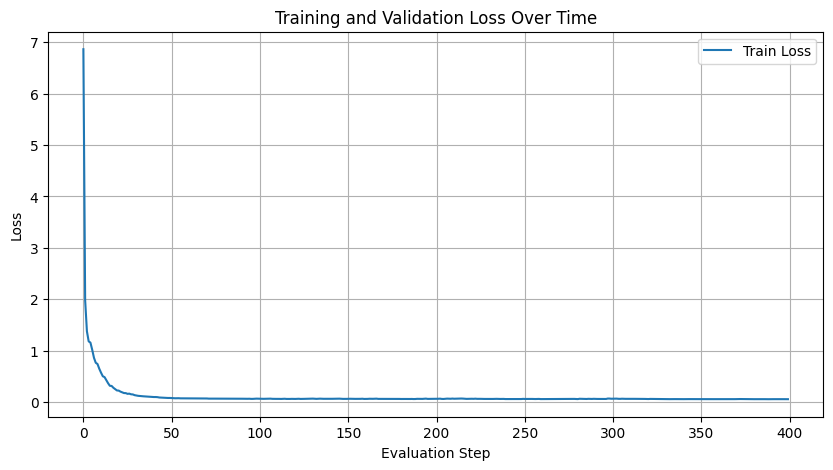

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

### 5. Inference

In [126]:
checkpoint_path = "../output/fine_tuning/qa/base/run_1/checkpoint_6.pth"
checkpoint = torch.load(checkpoint_path, weights_only=True)
model_state_dict = checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)

input_message = f"{tokens['start']}system{tokens['separator']}{system_message}{tokens['end']}"

user_message = "واش كتعرف عماد الصاديق؟"
input_message += f"{tokens['start']}user{tokens['separator']}{user_message}{tokens['end']}"
input_message += f"{tokens['start']}assistant{tokens['separator']}"

input_tokens = tokenizer.encode(input_message, allowed_special="all")
input_tokens = torch.tensor(input_tokens, dtype=torch.long)
input_tokens = input_tokens.unsqueeze(0).to(device)

model_answer = ""

model.eval()
while True:
    try:
        output_tokens = model.advanced_generation(
            input_tokens=input_tokens, max_new_tokens=1, temperature=.7, top_k=50, top_p=None)
        last_generated_token = output_tokens[0, -1].item()
        if last_generated_token == tokenizer.special_tokens["<|endoftext|>"]:
            break

        if last_generated_token == tokenizer.special_tokens["<|end_turn|>"]:
            break

        input_tokens = torch.cat((input_tokens, output_tokens[:, -1:]), dim=1)
        model_answer += tokenizer.decode([last_generated_token])

        if len(output_tokens[0]) > block_size:
            break
    except Exception:
        continue

print(f"You: {user_message}")
print(f"Assistant: {model_answer}")

You: واش كتعرف عماد الصاديق؟
Assistant: آه فهمت ولكن واخا هاكاك راه فاللخر كلشي زوين حيت بزاف ديال الحوايج بحال الكواكب، الألوان، الألوان، الأزرق، الأزرق، الأرض او التقوب السوداء.
